In [153]:
#Imports

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import Series, DataFrame
#import datetime
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import pairwise_logrank_test

In [154]:
#defining VIF function
#from DS14
def vif(df):
    '''
    VIF = variance inflation function
    '''
    # initialize dictionaries
    vif_dict = {}
    # X must be a dataframe and contain the independent variables only
    for var in df.columns:
        indep = [i for i in df.columns if i != var]
        X, y = df[indep], df[var]

        # extract r-squared from the fit
        #rsqr = LinearRegression().fit(X, y).score(X, y)
        model = sm.OLS(y,X).fit()
        rsqr = model.rsquared
        # calculate VIF
        vif = 1/(1 - rsqr)
        vif_dict[var] = vif

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict})

    return df_vif

#from towardsdatascience.com, Mr.Nair
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [155]:
#prep dataset
df = pd.read_csv('C:/Users/sofnl/Documents/BIU_DS/BIU_DS_Course/Stats/heart_failure_clinical_records_dataset.csv')
df

#convert nominal binary variables into categorical
for col in ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']:
    df[col] = df[col].astype('category')
#df.dtypes

In [156]:
#1.Create a linear regression for the “time” variable. Exclude the variable “DEATH_EVENT” from the analysis.

Y=df['time']
X=df[df.columns[:-2]]
X

model = sm.OLS(Y,X)
mod1 = model.fit()
print(mod1.summary())

#The condition number is large, 8.14e+05. This might indicate that there are
#strong multicollinearity or other numerical problems.

                                 OLS Regression Results                                
Dep. Variable:                   time   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.761
Method:                 Least Squares   F-statistic:                              87.75
Date:                Tue, 13 Sep 2022   Prob (F-statistic):                    3.64e-85
Time:                        09:23:43   Log-Likelihood:                         -1705.7
No. Observations:                 299   AIC:                                      3433.
Df Residuals:                     288   BIC:                                      3474.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [157]:
#checking for correlation between variables
#using spearman for non-normal distribution
df.corr(method='spearman')

#looks like there is no significant correlation between numeric X vars (all the coefficients are between +/-0.3)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
age,1.000000,-0.093078,0.074047,-0.052091,0.270561,-0.101716,-0.197524
creatinine_phosphokinase,-0.093078,1.000000,-0.067839,0.060033,-0.049936,0.016886,0.125823
ejection_fraction,0.074047,-0.067839,1.000000,0.053696,-0.177986,0.161695,0.070533
platelets,-0.052091,0.060033,0.053696,1.000000,-0.051028,0.049453,-0.006927
serum_creatinine,0.270561,-0.049936,-0.177986,-0.051028,1.000000,-0.300413,-0.160990
serum_sodium,-0.101716,0.016886,0.161695,0.049453,-0.300413,1.000000,0.086393
time,-0.197524,0.125823,0.070533,-0.006927,-0.160990,0.086393,1.000000


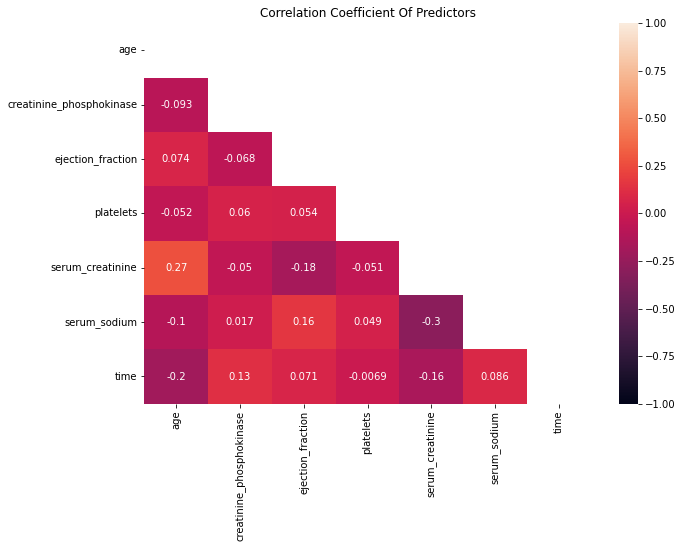

In [106]:
#visualizing correlation via heatmap

# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(method='spearman'), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(method='spearman'), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [158]:
#Recreate the linear regression excluding problematic variables if they exist.
#Checking vif
print(vif(df))

#Inflated Betas for age, ejection_fraction, serum_sodium; I think there is an implementation bug

                                VIF
DEATH_EVENT                2.476163
age                       30.400689
anaemia                    1.910127
creatinine_phosphokinase   1.458680
diabetes                   1.793319
ejection_fraction         13.355059
high_blood_pressure        1.646768
platelets                  8.644291
serum_creatinine           3.132862
serum_sodium              61.551253
sex                        3.810980
smoking                    1.892839
time                       5.657601


In [162]:
#Checking vif using Mr.Naif func
print(compute_vif(df.columns[:-2]))

#Got the same results in R; sticking with these results

#all the betas are between 1 and 2; no inflation due to correlations; 
#no need to remove variables 

                    Variable       VIF
0                        age  1.068365
1                    anaemia  1.066476
2   creatinine_phosphokinase  1.060983
3                   diabetes  1.064280
4          ejection_fraction  1.065725
5        high_blood_pressure  1.029255
6                  platelets  1.045777
7           serum_creatinine  1.069243
8               serum_sodium  1.096363
9                        sex  1.337709
10                   smoking  1.283023


C:\Users\sofnl\AppData\Local\Temp\ipykernel_10608\3535737232.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


In [18]:
#Relative Risk assesment: 
#params are coefficients
RR=np.exp(mod1.params)
round(RR, 7)

age                         0.313970
anaemia                     0.000000
creatinine_phosphokinase    0.994617
diabetes                    4.627189
ejection_fraction           1.302486
high_blood_pressure         0.000000
platelets                   0.999996
serum_creatinine            0.000659
serum_sodium                5.242436
sex                         0.868810
smoking                     0.000899
dtype: float64

The increased RR is observed for diabetes, ejection_fraction, serum_sodium
Extremely low RR is observed for anaemia, high_blood_pressure, serum_creatinine, and smoking;

In [163]:
#2.   Create a logistic regression model for the “DEATH_EVENT” variable. Exclude the “time” variable from the analysis
formula = '''DEATH_EVENT ~ age + anaemia + creatinine_phosphokinase + diabetes + 
              ejection_fraction + high_blood_pressure + platelets + serum_creatinine + 
              serum_sodium + sex + smoking'''

model = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
mod2 = model.fit()
print(mod2.summary())

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['DEATH_EVENT[0]', 'DEATH_EVENT[1]']   No. Observations:                  299
Model:                                              GLM   Df Residuals:                      287
Model Family:                                  Binomial   Df Model:                           11
Link Function:                                    Logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -147.14
Date:                                  Tue, 13 Sep 2022   Deviance:                       294.28
Time:                                          09:34:49   Pearson chi2:                     319.
No. Iterations:                                       5   Pseudo R-squ. (CS):             0.2375
Covariance Type:                              nonrobust                                         
                              

In [164]:
#checking betas using vif 
print(compute_vif(df.columns[:-2]))

                    Variable       VIF
0                        age  1.068365
1                    anaemia  1.066476
2   creatinine_phosphokinase  1.060983
3                   diabetes  1.064280
4          ejection_fraction  1.065725
5        high_blood_pressure  1.029255
6                  platelets  1.045777
7           serum_creatinine  1.069243
8               serum_sodium  1.096363
9                        sex  1.337709
10                   smoking  1.283023


C:\Users\sofnl\AppData\Local\Temp\ipykernel_10608\3535737232.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


all the betas are between 1 and 2; no inflation due to correlations; 
no need to remove variables 

Although, the values in R are different! In R, the values are obtained using a proper regression type, 
while here I have no way to pass the model, and internelly, vif built-in function seems to always use params from the lm model

In [165]:
#Odds Ratio calculation 
OR=np.exp(mod2.params)
OR

#Infering: anaemia, high blood pressure, gender and serum creatinine project the most death event risk (farthest from 1)

Intercept                   0.006983
anaemia[T.1]                0.658408
diabetes[T.1]               0.859497
high_blood_pressure[T.1]    0.657745
sex[T.1]                    1.490355
smoking[T.1]                0.873201
age                         0.945831
creatinine_phosphokinase    0.999710
ejection_fraction           1.072854
platelets                   1.000001
serum_creatinine            0.515891
serum_sodium                1.058303
dtype: float64

In [166]:
#3. Calculate the Kaplan-Meyer curve for the survival time, using the “time” and “DEATH_EVENT” variables.

kmf = KaplanMeierFitter() 
## Fit the data into the model
kmf.fit(df['time'], df['DEATH_EVENT'], label='Kaplan Meier Estimate')
kmf.survival_function_

,Kaplan Meier Estimate
timeline,
0.0,1.000000
4.0,0.996656
6.0,0.993311
7.0,0.986622
8.0,0.979933
...,...
270.0,0.575705
271.0,0.575705
278.0,0.575705


<AxesSubplot:xlabel='timeline'>

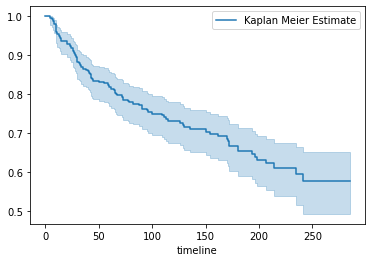

In [167]:
## Create an estimate
kmf.plot(ci_show=True)

<AxesSubplot:xlabel='timeline'>

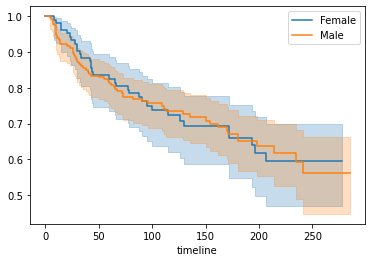

In [168]:
#Comparing survival times between males and females
#dividing data into groups
male = df.loc[df["sex"] ==1, ("time", "DEATH_EVENT")]
female = df.loc[df["sex"] ==0, ("time", "DEATH_EVENT")]

#creating kmf for each group
kmf_m = KaplanMeierFitter() 
kmf_f = KaplanMeierFitter() 

kmf_f.fit(durations=female["time"], event_observed=female["DEATH_EVENT"], label="Female")
kmf_m.fit(durations=male["time"], event_observed=male["DEATH_EVENT"], label="Male")

#visualizing surviving difference between genders
kmf_f.plot()
kmf_m.plot()

From the above graphs we can see that the survival curves of different genders are almost identical and seem statistically equivalent. Thus, performing the log-rank test.

In [169]:
lr=pairwise_logrank_test(df['time'], df['sex'], df['DEATH_EVENT'])
print(lr.summary)

     test_statistic         p  -log2(p)
0 1        0.003971  0.949752  0.074377


P value is very high, thus the two genders are indeed statistically equivalent.
Gender doesn't affect survival

<AxesSubplot:xlabel='timeline'>

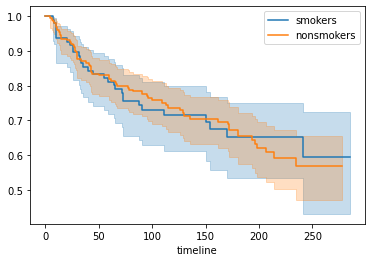

In [170]:
#Check if there is any difference between smokers and non-smokers
#dividing data into groups
smokers = df.loc[df["smoking"] ==1, ("time", "DEATH_EVENT")]
nonsmokers = df.loc[df["smoking"] ==0, ("time", "DEATH_EVENT")]

#creating kmf for each group
kmf_sm = KaplanMeierFitter() 
kmf_nsm = KaplanMeierFitter() 

kmf_sm.fit(durations=smokers["time"], event_observed=smokers["DEATH_EVENT"], label="smokers")
kmf_nsm.fit(durations=nonsmokers["time"], event_observed=nonsmokers["DEATH_EVENT"], label="nonsmokers")

#visualizing surviving difference between genders
kmf_sm.plot()
kmf_nsm.plot()

In [171]:
#The curves look statistically equivalent; performing log-rank test:
lr=pairwise_logrank_test(df['time'], df['smoking'], df['DEATH_EVENT'])
print(lr.summary)

#According to p value the groups are equivalent and the difference doesn't affect survival

     test_statistic        p  -log2(p)
0 1        0.002042  0.96396  0.052955


<AxesSubplot:xlabel='timeline'>

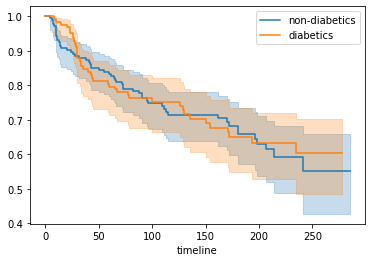

In [172]:
#Check if there is any difference between diabetics and non-diabetics
#dividing data into groups
dbt = df.loc[df["diabetes"] ==1, ("time", "DEATH_EVENT")]
ndbt = df.loc[df["diabetes"] ==0, ("time", "DEATH_EVENT")]

#creating kmf for each group
kmf_dbt = KaplanMeierFitter() 
kmf_ndbt = KaplanMeierFitter() 

kmf_dbt.fit(durations=ndbt["time"], event_observed=ndbt["DEATH_EVENT"], label="non-diabetics")
kmf_ndbt.fit(durations=dbt["time"], event_observed=dbt["DEATH_EVENT"], label="diabetics")

#visualizing surviving difference between genders
kmf_dbt.plot()
kmf_ndbt.plot()

In [173]:
#The curves look statistically equivalent; performing log-rank test:
lr=pairwise_logrank_test(df['time'], df['diabetes'], df['DEATH_EVENT'])
print(lr.summary)

#According to p value the groups are equivalent and the difference doesn't affect survival

     test_statistic         p  -log2(p)
0 1        0.040528  0.840452  0.250763


In [174]:
#Create a Cox regression using the “time” and “DEATH_EVENT” as the outcome; other variables as the independent predictors.
cph = CoxPHFitter() 
cph.fit(df[:-2], 'time', event_col='DEATH_EVENT')   
cph.print_summary() 


C:\Users\sofnl\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'category' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\sofnl\anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 297 total observations, 201 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 297
number of events observed = 96
   partial log-likelihood = -467.89
         time fit was run = 2022-09-13 08:34:18 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                        0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia                    0.46       1.58       0.22             0.03             0.88                 1.03                 2.41
creatinine_phosphokinase   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes                   0.13       1.14       0.22            -0.31             0.57                 0.74                 1.77
ejection_fraction         -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure        0.47       1.60       0.22             0.05             0.90                 1.05                 2.45
platelets                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine           0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium              -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                       -0.23       0.79       0.25            -0.73             0.26                 0.48                 1.30
smoking                    0.14       1.15       0.25            -0.35             0.63                 0.70                 1.88

                           cmp to     z      p   -log2(p)
covariate                                                
age                          0.00  4.90 <0.005      19.99
anaemia                      0.00  2.10   0.04       4.81
creatinine_phosphokinase     0.00  2.25   0.02       5.35
diabetes                     0.00  0.59   0.55       0.85
ejection_fraction            0.00 -4.64 <0.005      18.16
high_blood_pressure          0.00  2.18   0.03       5.11
platelets                    0.00 -0.41   0.68       0.55
serum_creatinine             0.00  4.58 <0.005      17.75
serum_sodium                 0.00 -1.88   0.06       4.07
sex                          0.00 -0.93   0.35       1.51
smoking                      0.00  0.55   0.58       0.78
---
Concordance = 0.74
Partial AIC = 957.78
log-likelihood ratio test = 80.41 on 11 df
-log2(p) of ll-ratio test = 39.57

In [175]:
print(compute_vif(df.columns[:-2]))
#all the betas are between 1 and 2; no inflation due to correlations, thus no need to remove vars

                    Variable       VIF
0                        age  1.068365
1                    anaemia  1.066476
2   creatinine_phosphokinase  1.060983
3                   diabetes  1.064280
4          ejection_fraction  1.065725
5        high_blood_pressure  1.029255
6                  platelets  1.045777
7           serum_creatinine  1.069243
8               serum_sodium  1.096363
9                        sex  1.337709
10                   smoking  1.283023


C:\Users\sofnl\AppData\Local\Temp\ipykernel_10608\3535737232.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


In [ ]:
#Calculate the exp of the estimates and based on the p-value determine which values increase the hazard of death(Hazard ratios).

#According to the exp and p in the model summary: age, anaemia, high blood pressure, and serum creatinine